In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

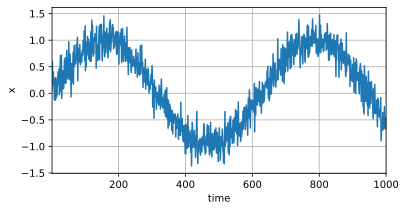

In [4]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
# T 
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射位数据对$y_t=x_t$和$\mathrm{x_t}$=[$x_{t-\tau}$,...,$x_{t-1}$]

In [16]:
tau = 4
# T-tau是样本数，tau是特证数
features = torch.zeros((T - tau , tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
#labels是样本
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

# features = [【x1, x2, x3, x4】,
#                   【x2, x3, x4, x5】,
#                    ...
#                   【x996, x997, x998, x999】
#             ]
# labels = [【x5】,
#              【x6】,
#              ...
#              【x1000】]


In [17]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [20]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss :{d2l.evaluate_loss(net, train_iter, loss):f}')
    
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss :0.054825
epoch 2, loss :0.054016
epoch 3, loss :0.059781
epoch 4, loss :0.051981
epoch 5, loss :0.051439


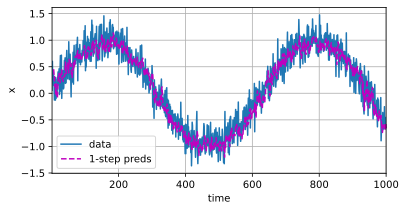

In [21]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

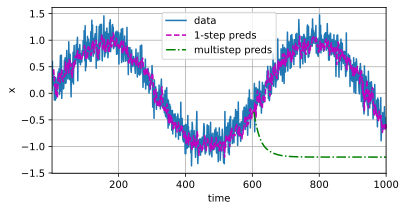

In [22]:
# 难点：预测比较远的未来
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

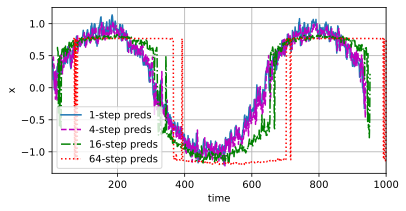

In [23]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))